In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.metrics import AUC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc, roc_auc_score

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_data= pd.read_csv('/content/drive/MyDrive/ColabData/twitter_2016/preprocessed_twitter_2016.csv')

In [4]:
train_data.head()

,Unnamed: 0,tweet,Subjectivity,Polarity,Analysis
0,0,rt _hockey: it’s gold gbr rio2016 hockey @_gbh…,0.000,0.000,Neutral
1,1,amazing! congratulations winning modernpentath...,0.825,0.625,Positive
2,2,wait. ashton eaton won decathlon gold again? yas!,0.000,0.000,Neutral
3,3,got shivers watching end chloe esposito's race...,0.000,0.000,Neutral
4,4,celebrating gold! effort! congratulations! 👍💪🏅,0.000,0.000,Neutral


In [5]:
# calculate word count of each sentence
train_data['word_counter'] = train_data['tweet'].apply(lambda x:len(str(x).split())) 

In [6]:
print('Info about training data:')
print(train_data['Analysis'].value_counts())
print('Total comments: ', len(train_data))

# will be used in cnn
max_train_sentence_length  = train_data['word_counter'].max()

Info about training data:
Neutral     48303
Positive    24413
Negative    10020
Name: Analysis, dtype: int64
Total comments:  82736


In [7]:
# will be used for padding
print('Train Max Sentence Length :'+str(max_train_sentence_length))

Train Max Sentence Length :29


In [8]:
# consider 30k comments
num_words = 30000

# convert texts to number format - for tensorflow.

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_data['tweet'].values.astype(str).tolist())

In [9]:
# splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(train_data['tweet'],\
                                                      train_data['Analysis'],\
                                                      test_size=0.1,\
                                                      random_state=0)

In [10]:
# text-to-number
x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )

#x_train = tokenizer.texts_to_matrix(X_train.values.astype(str))
#x_test  = tokenizer.texts_to_matrix(X_test.values.astype(str))

<ipython-input-10-3ebf70ccd52a>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
<ipython-input-10-3ebf70ccd52a>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )


In [11]:
# we get different length sentences after tokenizer.
# we need fixed size vectors. so padding is applied.
# max length of a sentence was given above. it was 3263.
# here we are taking maxlen=256 and applying padding (256 selected for computational cost)
x_train = pad_sequences(x_train, padding='post', maxlen=256)
x_test = pad_sequences(x_test, padding='post', maxlen=256)

In [12]:
# label encoding: 'positive', 'negative' and 'neutral' is converted to number format.
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

test_labels = le.transform(y_test)
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)

['Negative', 'Neutral', 'Positive']

In [13]:
print(train_labels[:10])

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [14]:
# looking for top 30k comments
max_features = 30000

#every index is represented by 64 dimensional vector
embedding_dim =64

#each input has 256 dimension
sequence_length = 256

model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(max_features, embedding_dim, input_length=sequence_length,\
                                   embeddings_regularizer = regularizers.l2(0.0005))) 

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', AUC(name='auc')])

In [15]:
# Training model

callbacks = [EarlyStopping(monitor='val_loss', patience=3)]

# Fit the model using the train and test datasets.
history = model.fit(x_train,
                    train_labels,
                    epochs= 10,
                    callbacks=callbacks,
                    validation_data=(x_test, test_labels),
                    verbose=1)

Epoch 1/10
2327/2327 [==============================] - 16s 6ms/step - loss: 0.1530 - accuracy: 0.9640 - auc: 0.9972 - val_loss: 0.0919 - val_accuracy: 0.9921 - val_auc: 0.9995
Epoch 2/10
2327/2327 [==============================] - 12s 5ms/step - loss: 0.0823 - accuracy: 0.9935 - auc: 0.9993 - val_loss: 0.0968 - val_accuracy: 0.9915 - val_auc: 0.9990
Epoch 3/10
2327/2327 [==============================] - 12s 5ms/step - loss: 0.0817 - accuracy: 0.9938 - auc: 0.9994 - val_loss: 0.0890 - val_accuracy: 0.9929 - val_auc: 0.9993
Epoch 4/10
2327/2327 [==============================] - 12s 5ms/step - loss: 0.0768 - accuracy: 0.9947 - auc: 0.9994 - val_loss: 0.0901 - val_accuracy: 0.9920 - val_auc: 0.9989
Epoch 5/10
2327/2327 [==============================] - 12s 5ms/step - loss: 0.0733 - accuracy: 0.9948 - auc: 0.9995 - val_loss: 0.0904 - val_accuracy: 0.9903 - val_auc: 0.9987
Epoch 6/10
2327/2327 [==============================] - 12s 5ms/step - loss: 0.0709 - accuracy: 0.9949 - auc: 0.999

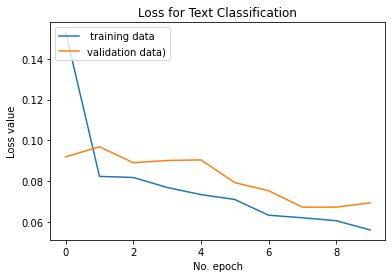

In [16]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

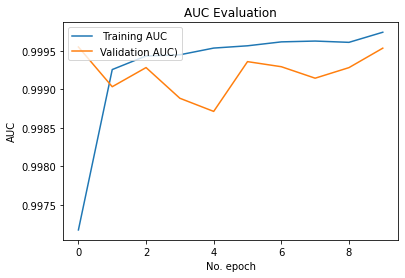

In [17]:
plt.plot(history.history['auc'], label=' Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC)')
plt.title('AUC Evaluation')
plt.ylabel('AUC')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [18]:
X_test

14268    save 53% ( morgan dollar(1896) $37.66 coins nu...
62381    2012 bowman sterling 13 vick ballard indianapo...
56367    ダブンダ〜！！！☆未開封 アメリカ 1971年 ダブルダイ入り プルーフ セット☆ 古銭 コ...
77865    goldprice fri, 19 aug 16 - 22:05 gmt | 1341.40...
22771    ksi daily report : friday, 19 august 2016 - ki...
                               ...                        
76749    spot gold price gone £1,025/toz £1,024.99/toz....
78098    goldprice fri, 19 aug 16 - 09:05 gmt | 1346.90...
17719    actus stop financial crises blockchain data st...
52310    solar knowledge power site: living earth expen...
77191    gold marked 50.00inr higher sharps pixley 31,1...
Name: tweet, Length: 8274, dtype: object

In [19]:
x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )
x_test2 = pad_sequences(x_test2, padding='post', maxlen=256)

<ipython-input-19-1bce84296b7e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )


In [20]:
# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
y_predictions = model.predict(x_test2)
y_pred = y_predictions.argmax(axis=1)
y_pred

Generate predictions for all samples
259/259 [==============================] - 0s 1ms/step


array([1, 1, 1, ..., 1, 0, 2])

In [21]:
y_pred = np.where((y_pred == 0),'Negative',y_pred)
y_pred = np.where((y_pred == '1'),'Neutral',y_pred)
y_pred = np.where((y_pred == '2'),'Positive',y_pred)

In [22]:
labels = ['Positive', 'Negative','Neutral']
print(classification_report(y_test, y_pred, labels=labels))

              precision    recall  f1-score   support

    Positive       0.99      1.00      0.99      2387
    Negative       0.97      0.99      0.98       988
     Neutral       1.00      0.99      0.99      4899

    accuracy                           0.99      8274
   macro avg       0.99      0.99      0.99      8274
weighted avg       0.99      0.99      0.99      8274

